# DS 3000 HW 3 

Due: Monday July 15th @ 11:59 PM EST

### Submission Instructions
Submit this `ipynb` file to Gradescope (this can also be done via the assignment on Canvas).  To ensure that your submitted files represent your latest code, make sure to give a fresh `Kernel > Restart & Run All` just before uploading the files to gradescope.

### Tips for success
- Start early
- Make use of Piazza
- Make use of Office hour
- Remember to use cells and headings to make the notebook easy to read (if a grader cannot find the answer to a problem, you will receive no points for it)
- Under no circumstances may one student view or share their ungraded homework or quiz with another student [(see also)](http://www.northeastern.edu/osccr/academic-integrity), though you are welcome to **talk about** (not show each other) the problems.

# Part 1: FIFA Players (30 points)

Create a plotly scatter plot which shows the mean `Overall` rating for all soccer players (rows) of a particular `Age`. Color your scatter plot per `Nationality` of the player, focusing on three countries (`England`, `Germany`, `Spain`). Download the `players_fifa23.csv` from Canvas and make sure it is in the same directory as this notebook file.

Export your graph as an html file `age_ratings_nationality.html` and submit it with your completed homework `ipynb` to gradescope.

Hints:
- There may be multiple ways/approaches to accomplish this task.
- One approach: you may use `groupby()` and boolean indexing to build these values in a loop which runs per each `Nationality`.
- `px.scatter()` will only graph data from columns (not the index).  Some approaches may need to graph data from the index.  You can use [df.reset_index()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html) to make your index a new column as shown [in this example](https://colab.research.google.com/drive/1d9JDphmpSTg9NtFMyfFnMQ6RmIx6zChK?usp=sharing)
- In some approaches you may need to pass multiple rows to [df.append()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html) if need be as shown [in this example](https://colab.research.google.com/drive/1XbBHMcYq_2Q225nkKs3j06iigCQGmM4H?usp=sharing)
- In some approaches you may need to go from "wide" data to "long" data by using [df.melt()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.melt.html) as discussed [here](https://towardsdatascience.com/reshaping-a-pandas-dataframe-long-to-wide-and-vice-versa-517c7f0995ad)
- The first few code cells below get you started with looking at the data set.

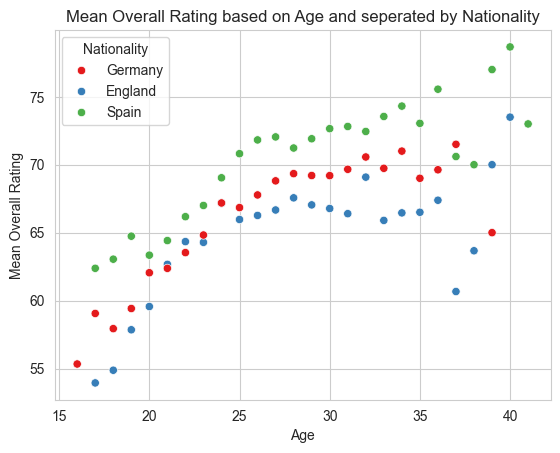

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# use pandas to read in the data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_fifa = pd.read_csv('players_fifa23.csv', index_col = 'ID')


countries = ['England', 'Germany', 'Spain']
df_fifa2 = df_fifa[df_fifa['Nationality'].isin(countries)]

df_fifa3 = df_fifa2.groupby(['Age', 'Nationality'])['Overall'].mean().reset_index()

sns.scatterplot(data=df_fifa3, x='Age', y='Overall', hue='Nationality', palette='Set1')

plt.title('Mean Overall Rating based on Age and seperated by Nationality')
plt.xlabel('Age')
plt.ylabel('Mean Overall Rating')

plt.savefig('age_ratings_nationality.png')

plt.show()


# Part 2: Daylight through the year

The remainder of the homework asks you to complete the pipeline which, given the lattitude / longitude and timezone of some cities:

``` python
loc_dict = {'Boston': (42.3601, -71.0589, 'US/Eastern'),
            'Lusaka': (-15.3875, 28.3228, 'Africa/Lusaka'),
            'Sydney': (-33.8688, 151.2093, 'Australia/Sydney')}
```

the keys are the `name` of the city and the values are tuples of `lat, lon, timezone_name

is able to:
- query a sunrise / sunset API
- clean and process data (timezone management & building `datetime` objects)

## Part 2.1: Getting Sunrise Sunset via API (20 points)
Write the `get_sunrise_sunset()` function below so that it uses [this sunrise sunset API](https://sunrise-sunset.org/api) to produce the result in the test case:

It may be helpful to know that this particular API...
- requires no api key
- returns about 2.5 queries per second
- did not block me when I tried to make 100 consecutive calls as quickly as possible

In [15]:
# you will need to run pip install requests in the terminal
# no need to install json, it is built into python
import requests
import json

# make sure to write a good docstring! I will do this for you for the other functions in this homework, but you should practice here!
def get_sunrise_sunset(lat, lng, date):
    """ fetches the sunrise sunset API information on a particular date for a given latitude-longitude
    
    Args:
        lat (float): latitude of interest
        lng (float): longitude of interest
        date (str): date of interest
        
    Returns:
        gss_dict (dictionary): a dictionary that contains the API information, as well as the arguments
    """   
    
    url = f'https://api.sunrise-sunset.org/json?lat={lat}&lng={lng}&date={date}'
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if data['status'] == 'OK':
            data['tzid'] = 'UTC'  
            data['lat-lng'] = (lat, lng)
            data['date'] = date
            return data
        else:
            raise ValueError(data['status'])
    else:
        response.raise_for_status()

In [16]:
sun_dict = get_sunrise_sunset(lat=42.3601, lng=-71.0589, date='2022-02-15')
sun_dict_expected = \
{'results': {'sunrise': '11:38:48 AM',
            'sunset': '10:17:50 PM',
            'solar_noon': '4:58:19 PM',
            'day_length': '10:39:02',
            'civil_twilight_begin': '11:11:30 AM',
            'civil_twilight_end': '10:45:08 PM',
            'nautical_twilight_begin': '10:38:37 AM',
            'nautical_twilight_end': '11:18:00 PM',
            'astronomical_twilight_begin': '10:06:05 AM',
            'astronomical_twilight_end': '11:50:33 PM'},
 'status': 'OK',
 'tzid': 'UTC',
 'lat-lng': (42.3601, -71.0589),
 'date': '2022-02-15'}

assert sun_dict == sun_dict_expected, 'get_sunrise_sunset() error'

## Part 2.2: (10 points)

A look at the API's documentation reminds us: 
    
    "NOTE: All times are in UTC and summer time adjustments are not included in the returned data."
    
Complete the `change_tz()` below so that it passes the given test case. 

In [41]:
import pytz
from datetime import datetime

def change_tz(dt, timezone_from, timezone_to):
    """ converts timezone of a timezone naive datetime object
    
    Args:
        dt (datetime): datetime (or time) object without timezone
        timezone_from (str): timezone of input
        timezone_to (str): timezone of output datetime
        
    Returns:
        dt (datetime): datetime object corresponding to 
            unix_time
    """
    tz = pytz.timezone(timezone_from)
    dt_tz = tz.localize(dt)
    
    tz_to = pytz.timezone(timezone_to)
    dt = dt_tz.astimezone(tz_to)
    
    return dt

In [42]:
# If things work, you should not get an error in this block
# build test case input / output
dt_no_tz = datetime(2021, 2, 13, 9, 54, 4, 270088)
dt_expect = datetime(2021, 2, 13, 14, 54, 4, 270088, tzinfo=pytz.timezone('GMT'))

# compute actual output
dt = change_tz(dt_no_tz, timezone_from='US/Eastern', timezone_to='GMT')

assert dt == dt_expect, 'change_tz() error'

## Part 2.3: (25 points)
Build `clean_sun_dict()` to pass each of the two test cases below.  Note that:
- sunrise and sunset are `time` objects which account for daylight's saving:
    - include the date when building these objects
    - use `change_tz()` above to cast them to the proper timezone
    - build `time` objects by calling `datetime.time()` to discard the date of a `datetime`
    - importing `pandas as pd` and using `pd.to_datetime` may also be helpful
- `sunrise_hr` and `sunset_hr` are the hours since the day began in local timezone (more easily graphed)
    - you may use `.strftime()` and `int()` to cast time objects to strings and then integers (which may be helpful) 
    
**NOTE:** There may be more than one way to accomplish writing this function; as long as the function passes both `assert` test cases, you may continue. Just do be sure to comment and present your code as cleanly as possible.

In [45]:
from datetime import datetime, time
import pandas as pd

def clean_sun_dict(sun_dict, timezone_to):
    """ builds pandas series and cleans output of API
    
    Args:
        sun_dict (dict): dict of json (see ex below)
        timezone_to (str): timezone of outputs (API returns
            UTC times)
            
    Returns:
        sun_series (pd.Series): all times converted to
            time objects
    
    example sun_series:
    
    date            2021-02-13 00:00:00
    lat-lng        (36.72016, -4.42034)
    sunrise                    02:11:06
    sunrise_hr                    2.185
    sunset                     13:00:34
    sunset_hr                   13.0094
    dtype: object
    """
    date_string = sun_dict['date']
    date = datetime.strptime(date_string, '%Y-%m-%d')
    lat_lng = sun_dict['lat-lng']
    
    sunrise_utc_string = sun_dict['results']['sunrise']
    sunset_utc_string = sun_dict['results']['sunset']
    
    sunrise_utc = pd.to_datetime(f"{date_string} {sunrise_utc_string}", utc=True)
    sunset_utc = pd.to_datetime(f"{date_string} {sunset_utc_string}", utc=True)
    
    sunrise_local = change_tz(sunrise_utc, 'UTC', timezone_to)
    sunset_local = change_tz(sunset_utc, 'UTC', timezone_to)
    
    sunrise = sunrise_local.time()
    sunset = sunset_local.time()
    
    sunrise_hr = sunrise_local.hour + sunrise_local.minute / 60 + sunrise_local.second / 3600
    sunset_hr = sunset_local.hour + sunset_local.minute / 60 + sunset_local.second / 3600

    sun_series = pd.Series({
        'date': date,
        'lat-lng': lat_lng,
        'sunrise': sunrise,
        'sunrise_hr': sunrise_hr,
        'sunset': sunset,
        'sunset_hr': sunset_hr
    })
    
    return sun_series

In [46]:
sun_dict = {'results': {'sunrise': '11:38:48 AM',
                        'sunset': '10:17:50 PM',
                        'solar_noon': '4:58:19 PM',
                        'day_length': '10:39:02',
                        'civil_twilight_begin': '11:11:30 AM',
                        'civil_twilight_end': '10:45:08 PM',
                        'nautical_twilight_begin': '10:38:37 AM',
                        'nautical_twilight_end': '11:18:00 PM',
                        'astronomical_twilight_begin': '10:06:05 AM',
                        'astronomical_twilight_end': '11:50:33 PM'},
             'status': 'OK',
             'lat-lng': (42.3601, -71.0589),
             'date': '2022-02-15'}

# test without timezone conversion
sun_series = clean_sun_dict(sun_dict, timezone_to='GMT')

sun_series_exp = pd.Series(
{'date': datetime(year=2022, month=2, day=15),
'lat-lng': (42.3601, -71.0589),
'sunrise': time(hour=11, minute=38, second=48),
'sunrise_hr': 11.646666666666667,
'sunset': time(hour=22, minute=17, second=50),
'sunset_hr': 22.297222222222224})

assert sun_series.eq(sun_series_exp).all(), 'clean_sun_dict() error (GMT)'

AssertionError: clean_sun_dict() error (GMT)

In [33]:
# test with timezone conversion
sun_series = clean_sun_dict(sun_dict, timezone_to='US/Eastern',)

sun_series_exp = pd.Series(
{'date': datetime(year=2022, month=2, day=15),
'lat-lng': (42.3601, -71.0589),
'sunrise': time(hour=6, minute=38, second=48),
'sunrise_hr': 6.6466666666666665,
'sunset': time(hour=17, minute=17, second=50),
'sunset_hr': 17.297222222222224})

assert sun_series.eq(sun_series_exp).all(), 'clean_sun_dict() error (EST)'

ValueError: Not naive datetime (tzinfo is already set)

## Part 2.4: (15 points)

Write the `get_annual_sun_data()` function so that it produces the outputs shown below.  This function should make use of:
 - `get_sunrise_sunset()`
 - `clean_sun_dict()`
   
as built above.

The following snippet:

```python
loc_dict = {'Boston': (42.3601, -71.0589, 'US/Eastern'),
            'Lusaka': (-15.3875, 28.3228, 'Africa/Lusaka'),
            'Sydney': (-33.8688, 151.2093, 'Australia/Sydney')}
df_annual_sun = get_annual_sun_data(loc_dict, year=2021, period_day=30)
df_annual_sun.head(15)
```

should generate:

|    |   city |       date |              lat-lng |  sunrise | sunrise_hr |   sunset | sunset_hr |
|---:|-------:|-----------:|---------------------:|---------:|-----------:|---------:|----------:|
|  0 | Boston | 2021-01-01 |  (42.3601, -71.0589) | 07:11:49 |   7.196944 | 16:24:12 | 16.403333 |
|  1 | Lusaka | 2021-01-01 |  (-15.3875, 28.3228) | 05:38:33 |   5.642500 | 18:42:09 | 18.702500 |
|  2 | Sydney | 2021-01-01 | (-33.8688, 151.2093) | 05:46:24 |   5.773333 | 20:10:53 | 20.181389 |
|  3 | Boston | 2021-01-31 |  (42.3601, -71.0589) | 06:56:43 |   6.945278 | 16:58:42 | 16.978333 |
|  4 | Lusaka | 2021-01-31 |  (-15.3875, 28.3228) | 05:55:43 |   5.928611 | 18:44:35 | 18.743056 |
|  5 | Sydney | 2021-01-31 | (-33.8688, 151.2093) | 06:14:24 |   6.240000 | 20:02:42 | 20.045000 |
|  6 | Boston | 2021-03-02 |  (42.3601, -71.0589) | 06:15:41 |   6.261389 | 17:36:50 | 17.613889 |
|  7 | Lusaka | 2021-03-02 |  (-15.3875, 28.3228) | 06:06:23 |   6.106389 | 18:31:11 | 18.519722 |
|  8 | Sydney | 2021-03-02 | (-33.8688, 151.2093) | 06:42:34 |   6.709444 | 19:32:04 | 19.534444 |
|  9 | Boston | 2021-04-01 |  (42.3601, -71.0589) | 06:24:21 |   6.405833 | 19:11:35 | 19.193056 |
| 10 | Lusaka | 2021-04-01 |  (-15.3875, 28.3228) | 06:11:08 |   6.185556 | 18:09:54 | 18.165000 |
| 11 | Sydney | 2021-04-01 | (-33.8688, 151.2093) | 07:06:04 |   7.101111 | 18:52:05 | 18.868056 |
| 12 | Boston | 2021-05-01 |  (42.3601, -71.0589) | 05:37:09 |   5.619167 | 19:45:25 | 19.756944 |
| 13 | Lusaka | 2021-05-01 |  (-15.3875, 28.3228) | 06:16:13 |   6.270278 | 17:51:21 | 17.855833 |
| 14 | Sydney | 2021-05-01 | (-33.8688, 151.2093) | 06:28:28 |   6.474444 | 17:16:05 | 17.268056 |

In [47]:
from datetime import timedelta

def get_annual_sun_data(loc_dict, year=2021, period_day=30): 
    """ pulls evenly spaced sunrise / sunsets from API over year per city
    
    Args:
        loc_dict (dict): keys are cities, values are tuples of 
            (lat, lon, tz_str) where tz_str is a timezone
            string included in pytz.all_timezones
        year (int): year to query
        period_day (int): how many days between data queries
            (i.e. period_day=1 will get every day for the year)
            
    Returns:
        df_annual_sun (DataFrame): each row represents a 
            sunrise / sunset datapoint, see get_sunrise_sunset()
    """
    data = []

    for city, (lat, lon, tz_str) in loc_dict.items():
        date = datetime(year, 1, 1)
        while date.year == year:
            sun_dict = get_sunrise_sunset(lat, lon, date)

            sun_series = clean_sun_dict(sun_dict, tz_str)

            sun_series['city'] = city

            data.append(sun_series.to_dict())

            date += timedelta(days=period_day)
    df = pd.DataFrame(data)
    
    return df

Once you have finished the function, you should be able to run the following codes to get the result. 

In [48]:
loc_dict = {'Boston': (42.3601, -71.0589, 'US/Eastern'),
            'Lusaka': (-15.3875, 28.3228, 'Africa/Lusaka'),
            'Sydney': (-33.8688, 151.2093, 'Australia/Sydney')}

# you may find that setting period_day to a larger value is quicker for debug
# period_day=5 takes about a minute or so given the API does 2-3 requests / sec
df_annual_sun = get_annual_sun_data(loc_dict, year=2021, period_day=30)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [49]:
df_annual_sun.head(15)

NameError: name 'df_annual_sun' is not defined